# DATA ANALYSIS

## CONTENT: 

- [Time as a seasonal value dat_forecast](#time-seasonality-date_forecast)
- []()
- []()

Code below makes imports for plotting data

In [2]:
# directly from precode
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

## Time seasonality `date_forecast`

The `date_forecast` value in itself does not give us a lot of information as it is only a linear value (Increasing time and date). While the real world time moves in seasons and in our case we are interested in the two periods throughout the day and also throughout the year. We can use sinus and / or cosinus in order to induce seasonality into our dataset for the time attribute. This however introduces an extra issues.... (see [below](#issues-with-only-sinus-or-cosinus-as-seasonal-transformation-function))

In [3]:
def list_directory_tree_with_os_walk(starting_directory):
    for root, directories, files in os.walk(starting_directory):
        print(f"Directory: {root}")
        for file in files:
            print(f"  File: {file}")

data_path = "../../../data/"
list_directory_tree_with_os_walk(data_path)

Directory: ../../../data/
  File: .DS_Store
  File: test.csv
  File: Readme.md
  File: sample_submission.csv
  File: read_files.ipynb
Directory: ../../../data/A
  File: X_train_observed.parquet
  File: train_targets.parquet
  File: X_train_estimated.parquet
  File: X_test_estimated.parquet
Directory: ../../../data/.ipynb_checkpoints
  File: my_first_submission-checkpoint.csv
  File: read_files-checkpoint.ipynb
Directory: ../../../data/C
  File: X_train_observed.parquet
  File: train_targets.parquet
  File: X_train_estimated.parquet
  File: X_test_estimated.parquet
Directory: ../../../data/B
  File: X_train_observed.parquet
  File: train_targets.parquet
  File: X_train_estimated.parquet
  File: X_test_estimated.parquet


In [4]:
test_file_path = data_path + "/A/X_train_observed.parquet"
df = pd.read_parquet(test_file_path)
date_time = df['date_forecast']
unix_time = (date_time - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
print(f"Date time:\n{date_time.head()}\n\nUnix Time:\n {unix_time.head()}")


Date time:
0   2019-06-02 22:00:00
1   2019-06-02 22:15:00
2   2019-06-02 22:30:00
3   2019-06-02 22:45:00
4   2019-06-02 23:00:00
Name: date_forecast, dtype: datetime64[us]

Unix Time:
 0    1559512800
1    1559513700
2    1559514600
3    1559515500
4    1559516400
Name: date_forecast, dtype: int64


<Axes: xlabel='date_forecast'>

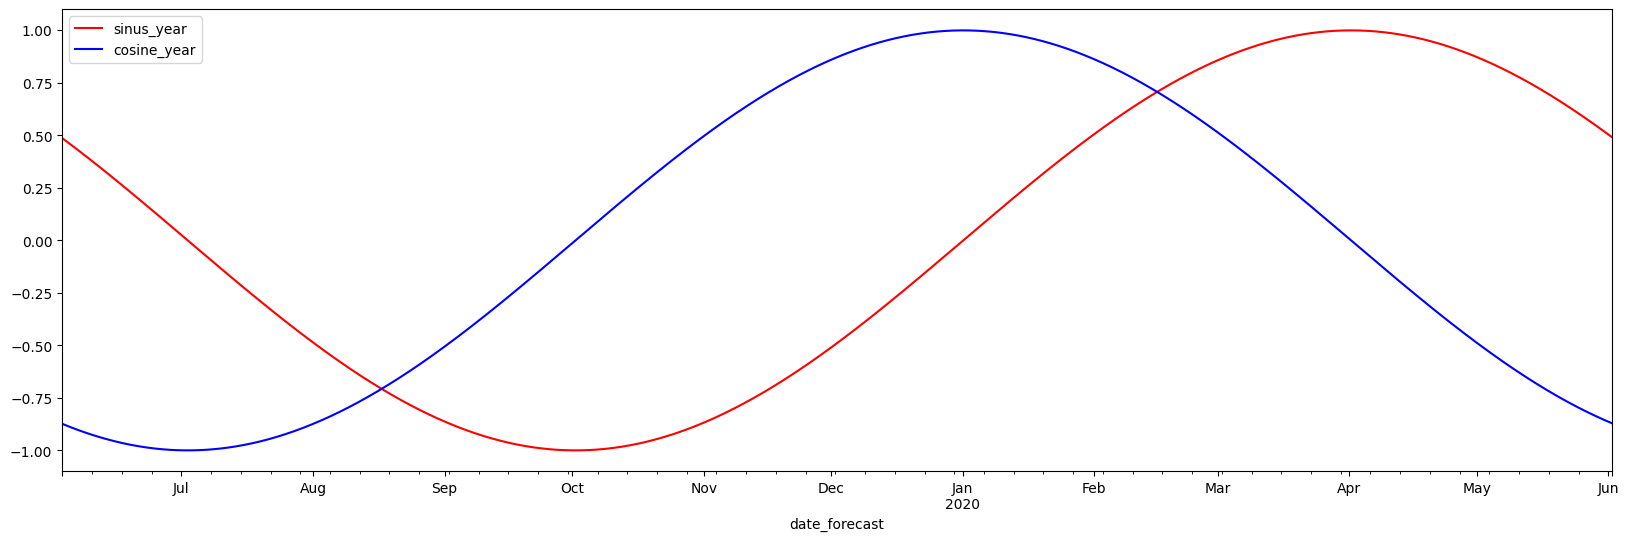

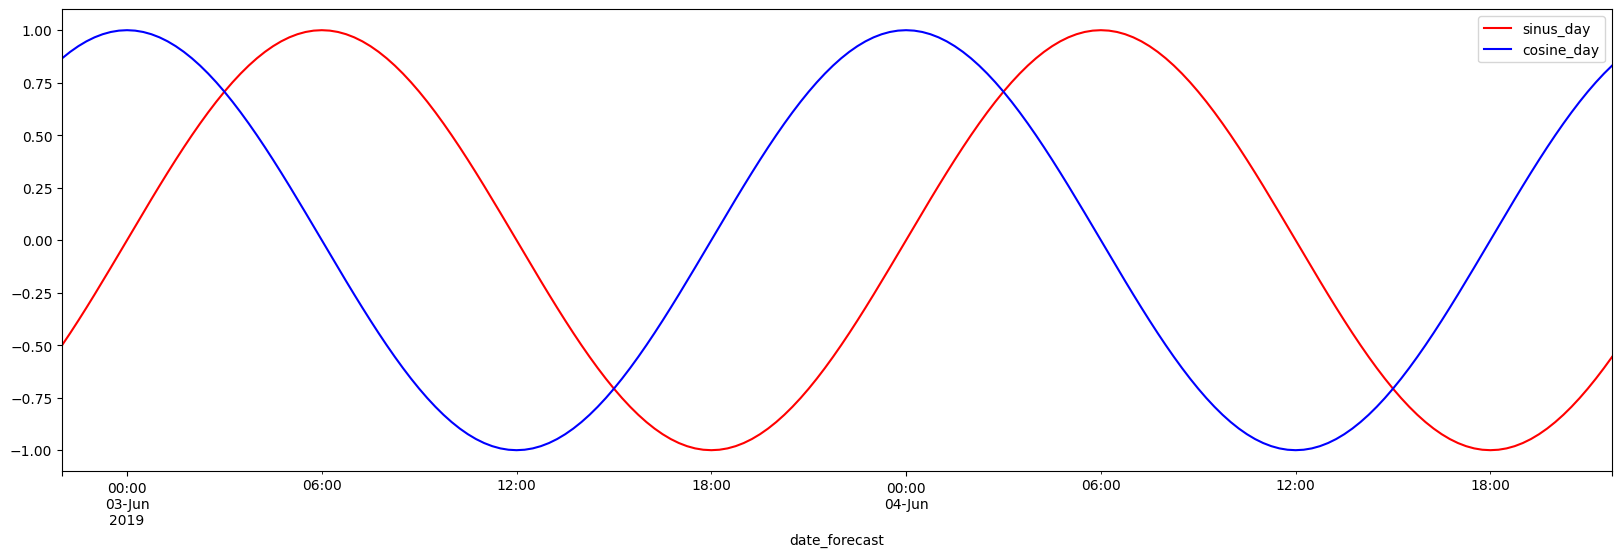

In [5]:

day = 24*60*60
year = (365.2425)*day

def sinus_day(unix_time):
    return np.sin(unix_time * (2 * np.pi / day)) # since it is seconds since 1.1.1970 we divide by seconds in a day to get seasonal changes throughout the dat

def sinus_year(unix_time):
    return np.sin(unix_time * (2 * np.pi / year))

def cosinus_day(unix_time):
    return np.cos(unix_time * (2 * np.pi / day))

def cosinus_year(unix_time):
    return np.cos(unix_time * (2 * np.pi / year))

# sinus
sinus_day_time = unix_time.apply(sinus_day)
sinus_day_time = sinus_day_time.rename('sinus_day')
sinus_year_time = unix_time.apply(sinus_year)
sinus_year_time = sinus_year_time.rename('sinus_year')

# cosinus
cosinus_day_time = unix_time.apply(cosinus_day)
cosinus_day_time = cosinus_day_time.rename('cosine_day')
cosinus_year_time = unix_time.apply(cosinus_year)
cosinus_year_time = cosinus_year_time.rename('cosinus_year')

week_datetime = date_time[0:48*4]
week = sinus_day_time[0:48*4] #168 = hours through a week, datapoints every 15 minutes
week_frame = pd.merge(week_datetime, week, left_index=True, right_index=True)
week_frame['cosine_day'] = cosinus_day_time[0:48*4]

year_sin = sinus_year_time[0:24*4*365] #datapoints every 15 minutes
year_cos = cosinus_year_time[0:24*4*365]
year_datetime = date_time[0:24*4*365]
year_frame = pd.merge(year_datetime, year_sin, left_index=True, right_index=True)
year_frame['cosine_year'] = year_cos[0:24*4*365]

fig, axs = plt.subplots(1, 1, figsize=(20,6), sharex=True)
year_frame.plot(x='date_forecast', y='sinus_year', kind='line', ax=axs, color='red')
year_frame.plot(x='date_forecast', y='cosine_year', kind='line', ax=axs, color='blue')

fig2, axx = plt.subplots(1, 1, figsize=(20,6), sharex=True)
week_frame.plot(x='date_forecast', y='sinus_day', kind='line', ax = axx, color='red')
week_frame.plot(x='date_forecast', y='cosine_day', kind='line', ax = axx, color='blue')


### Issues with only sinus or cosinus as seasonal transformation function
Looking at the plots above we kan see that only looking at sinus (red line) gives us seasonality at first glance but it oscilates such that July and january gets the same value. In fact we get to values that are the same at any y value that is between `(1, -1)`. And as we move towards 0 the intuitive error of the two corresponding x-axes to be the same increases. As in the example of july and january above.

To solve this we introduce another seasonal funciton of cosine such that every x has a unique tuple value `(sin(x), cos(x))`. Now we have a way of representing time as a seasonal vairable both for yearly variations and daily variations. This is probably the most important metric we can get from the time dimension since weather and sunlight is an important part of powerproduction. Weekly and monthly aspects are not that interesting since a 7-day cycle or 30-day cycle shouldn't have anything to say on the production of solar power. However, daily and yearly makes sense since the sunlight changes through the day every day, and the distance between earth and sun vary yearly. 

### Negative values in prediction

Some predictionmodels does not like negative or 0 values when fitting a model. Thus a quick fix for the seasonality is to add 2 in the conversion functions to sinus and cosine

## NULL values in the dataset

The dataset provided has some null values for certain columns. Many prediction models does not work well with `NULL` in the dataset. Therefore we might need to fill or remove these values. 

To get some statistics about which columns has the most `NULL` values, we can do the following: 

In [10]:
test_file_paths = [data_path + "/A/X_train_observed.parquet", 
                   data_path + "/A/X_train_estimated.parquet",
                   data_path + "/B/X_train_observed.parquet", 
                   data_path + "/B/X_train_estimated.parquet",
                   data_path + "/C/X_train_observed.parquet", 
                   data_path + "/C/X_train_estimated.parquet"]
def get_null_val_stat(df: pd.DataFrame):
    for column in df.columns:
        null_c =  df[column].isna().sum()
        if null_c > 0: 
            print(f'Column: {column} has {null_c} NULL values')


for path in test_file_paths:
    print('')
    print(path)
    df = pd.read_parquet(test_file_path)
    df.plot(x='date_forecast', y='sinus_year', kind='line', ax=axs, color='red')
    get_null_val_stat(df)


../../../data//A/X_train_observed.parquet
Column: ceiling_height_agl:m has 22247 NULL values
Column: cloud_base_agl:m has 8066 NULL values
Column: snow_density:kgm3 has 115945 NULL values

../../../data//A/X_train_estimated.parquet
Column: ceiling_height_agl:m has 22247 NULL values
Column: cloud_base_agl:m has 8066 NULL values
Column: snow_density:kgm3 has 115945 NULL values

../../../data//B/X_train_observed.parquet
Column: ceiling_height_agl:m has 22247 NULL values
Column: cloud_base_agl:m has 8066 NULL values
Column: snow_density:kgm3 has 115945 NULL values

../../../data//B/X_train_estimated.parquet
Column: ceiling_height_agl:m has 22247 NULL values
Column: cloud_base_agl:m has 8066 NULL values
Column: snow_density:kgm3 has 115945 NULL values

../../../data//C/X_train_observed.parquet
Column: ceiling_height_agl:m has 22247 NULL values
Column: cloud_base_agl:m has 8066 NULL values
Column: snow_density:kgm3 has 115945 NULL values

../../../data//C/X_train_estimated.parquet
Column: c

The example above is only for location A and the observed x_values.

Since it is very few columns, one quick fix would be to simply drop these. 

Another solution is to induce a value into the `NULL` rows either based on previous and following values, or simply just set a chosen value. For *snow density* there might be the case that a fixed value for the `NULL` is the best option. Maybe a number like -1 since the it seems like the `NULL` comes when there is no snow to measure the density on. 

## Certification and binary values

### Boolean values: 
- `is_day:idx` -> 0/1
- `is_in_shadow:idx` -> 0/1

### Other int values:
- `dew_or_rime` -> (dew=1, rime=-1, neither=0)
- `elevation` -> The elevation of the solar_panel above ground. This is a static value. We train per location so this does not make sense for us to use. 
- `precip_type_5min:idx` -> precipitation type during the previous time period (5min)

In [7]:
df['precip_type_5min:idx'].unique()

array([0., 1., 3., 2., 6., 5., 4.], dtype=float32)

In [8]:
df['dew_or_rime:idx'].unique()

array([ 0.,  1., -1.], dtype=float32)